# 09 特征可视化

> 理解 CNN "看到了什么"

---

## 📚 学习目标

- [ ] 可视化卷积核
- [ ] 可视化特征图
- [ ] 使用 Grad-CAM 解释模型决策

In [7]:
import numpy as np
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    import torchvision.models as models
    import torchvision.transforms as transforms
    from PIL import Image
    HAS_TORCH = True
except ImportError:
    HAS_TORCH = False
    print("请安装 PyTorch")

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False

---

# Part 1: 准备工作

## 1.1 加载模型和真实图片

In [13]:
# ============================================================
# 加载本地图片
# ============================================================

import urllib.request
import os
from glob import glob

# 获取 notebook 所在目录
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
image_dir = os.path.join(notebook_dir, 'sample_images')

# 如果找不到，尝试其他路径
if not os.path.exists(image_dir):
    image_dir = './sample_images'
if not os.path.exists(image_dir):
    image_dir = '../sample_images'

print(f"图片目录: {image_dir}")
print(f"目录存在: {os.path.exists(image_dir)}")

# 查找已有图片
image_paths = {}
if os.path.exists(image_dir):
    for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']:
        for path in glob(os.path.join(image_dir, ext)):
            name = os.path.splitext(os.path.basename(path))[0]
            image_paths[name] = path

print(f"\n找到 {len(image_paths)} 张图片：")
for name, path in image_paths.items():
    print(f"  - {name}: {path}")

# 设置标志
USE_REAL_IMAGES = len(image_paths) > 0

if not USE_REAL_IMAGES:
    print("\n⚠️ 没有找到图片，将使用随机图像演示")
    print(f"请确保图片放在: {image_dir}")

图片目录: /Users/lyh/Desktop/ Machine Learning/deep_learning/4.1_cnn/sample_images
目录存在: True

找到 2 张图片：
  - Cat03: /Users/lyh/Desktop/ Machine Learning/deep_learning/4.1_cnn/sample_images/Cat03.jpg
  - YellowLabradorLooking_new: /Users/lyh/Desktop/ Machine Learning/deep_learning/4.1_cnn/sample_images/YellowLabradorLooking_new.jpg


✅ 模型加载完成
✅ 加载 1000 个 ImageNet 类别标签


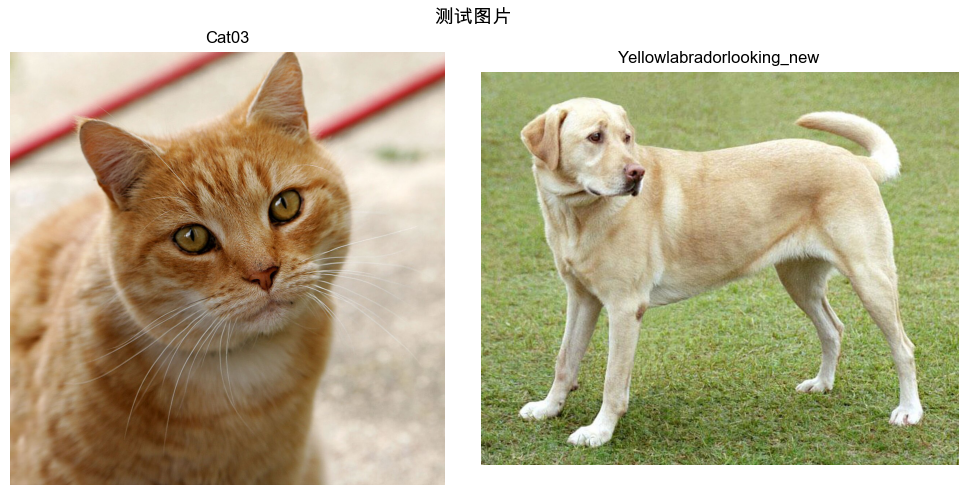

In [14]:
# ============================================================
# 图片预处理和模型加载
# ============================================================

# ImageNet 预处理
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def load_and_preprocess(image_path):
    """加载并预处理图片"""
    img = Image.open(image_path).convert('RGB')
    img_tensor = preprocess(img).unsqueeze(0)
    return img, img_tensor

def denormalize(tensor):
    """反归一化用于显示"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# 加载预训练的 ResNet-18
model = models.resnet18(weights='DEFAULT')
model.eval()
print("✅ 模型加载完成")

# 加载 ImageNet 类别标签
IMAGENET_LABELS_URL = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
try:
    with urllib.request.urlopen(IMAGENET_LABELS_URL) as f:
        imagenet_labels = [line.decode('utf-8').strip() for line in f.readlines()]
    print(f"✅ 加载 {len(imagenet_labels)} 个 ImageNet 类别标签")
except:
    imagenet_labels = [f"class_{i}" for i in range(1000)]
    print("⚠️ 无法加载类别标签，使用默认名称")

# 显示图片（只有找到图片时才显示）
if USE_REAL_IMAGES and len(image_paths) > 0:
    n_images = len(image_paths)
    fig, axes = plt.subplots(1, n_images, figsize=(5*n_images, 5))
    
    # 确保 axes 是列表（只有1张图时是单个对象）
    if n_images == 1:
        axes = [axes]
    
    for ax, (name, path) in zip(axes, image_paths.items()):
        img = Image.open(path)
        ax.imshow(img)
        ax.set_title(name.capitalize())
        ax.axis('off')
    
    plt.suptitle('测试图片', fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ 没有找到图片，后续将使用随机图像演示")

---

# Part 2: 特征图可视化

## 2.1 不同层的特征图

CNN 的不同层学习不同层次的特征：
- **浅层**：边缘、颜色、纹理
- **中层**：形状、部件
- **深层**：高级语义（如"眼睛"、"轮子"）

预测类别: Egyptian cat (class 285)


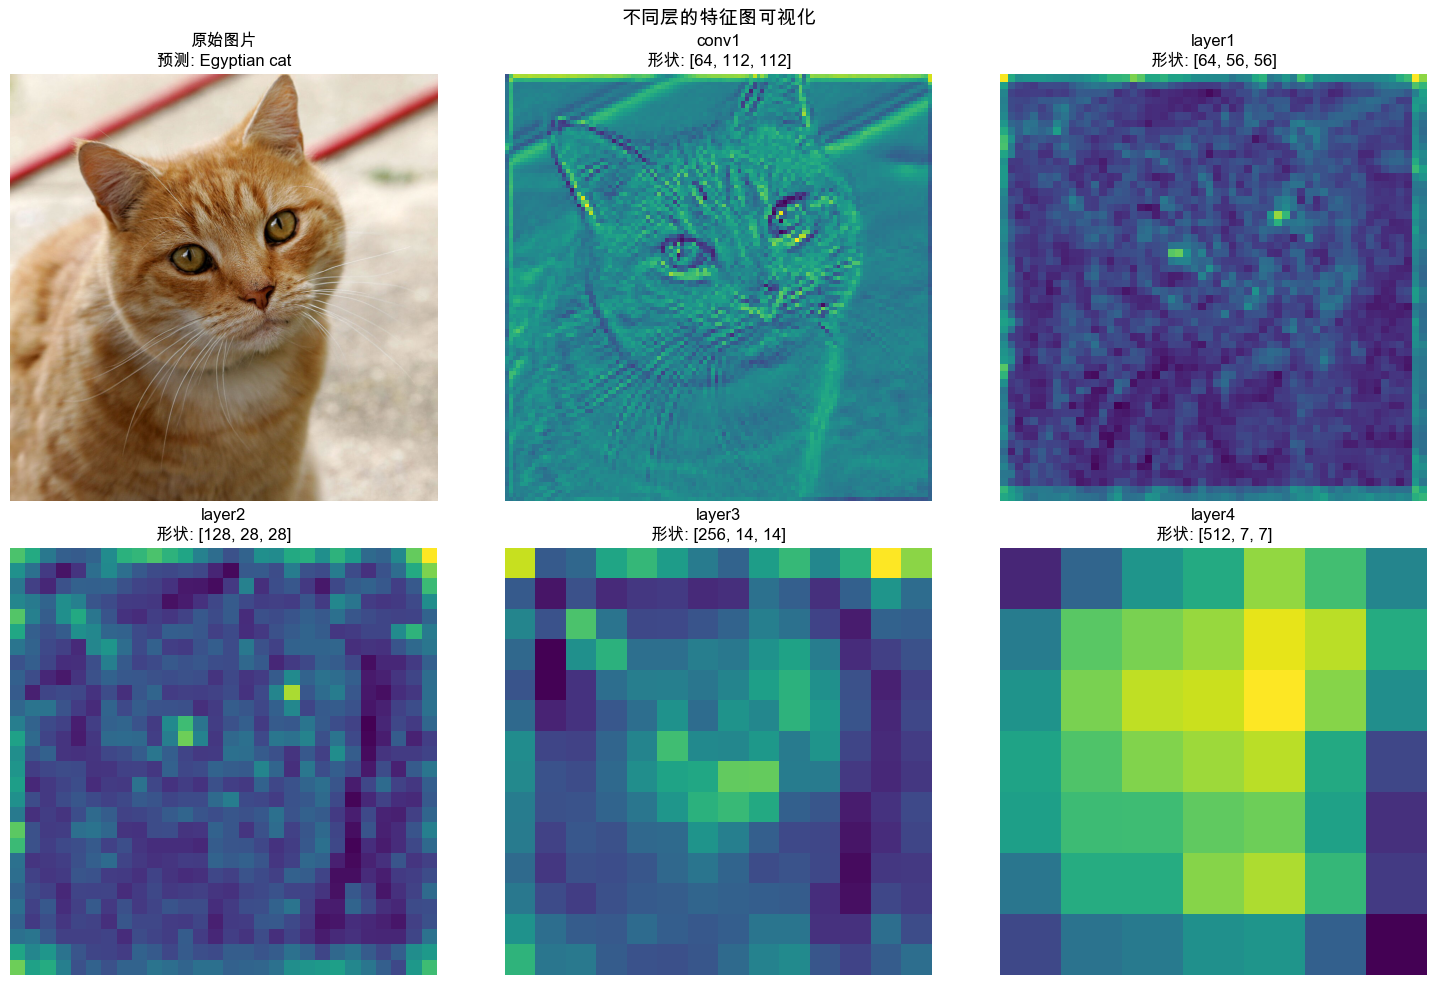


💡 观察：
   - 浅层 (conv1): 保留空间细节，响应边缘和纹理
   - 深层 (layer4): 空间尺寸小，但语义信息丰富


In [15]:
# ============================================================
# 特征图可视化：使用真实图片
# ============================================================

# 注册 hook 捕获中间层输出
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# 注册到不同深度的层
hooks = []
hooks.append(model.conv1.register_forward_hook(get_activation('conv1')))
hooks.append(model.layer1.register_forward_hook(get_activation('layer1')))
hooks.append(model.layer2.register_forward_hook(get_activation('layer2')))
hooks.append(model.layer3.register_forward_hook(get_activation('layer3')))
hooks.append(model.layer4.register_forward_hook(get_activation('layer4')))

# 选择一张图片进行可视化
if USE_REAL_IMAGES:
    test_image_path = image_paths.get('cat', list(image_paths.values())[0])
    original_img, img_tensor = load_and_preprocess(test_image_path)
else:
    img_tensor = torch.randn(1, 3, 224, 224)
    original_img = None

# 前向传播
with torch.no_grad():
    output = model(img_tensor)
    pred_class = output.argmax().item()
    pred_label = imagenet_labels[pred_class]

print(f"预测类别: {pred_label} (class {pred_class})")

# 可视化不同层的特征图
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 原始图片
if original_img:
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title(f'原始图片\n预测: {pred_label}')
else:
    img_display = denormalize(img_tensor[0]).permute(1, 2, 0).numpy()
    img_display = np.clip(img_display, 0, 1)
    axes[0, 0].imshow(img_display)
    axes[0, 0].set_title('输入图片')
axes[0, 0].axis('off')

# 各层特征图（取第一个通道）
layer_names = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4']
positions = [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for name, pos in zip(layer_names, positions):
    feat = activations[name][0]  # 去掉 batch 维度
    
    # 取所有通道的平均（更有代表性）
    feat_avg = feat.mean(dim=0).numpy()
    
    ax = axes[pos[0], pos[1]]
    im = ax.imshow(feat_avg, cmap='viridis')
    ax.set_title(f'{name}\n形状: {list(feat.shape)}')
    ax.axis('off')

plt.suptitle('不同层的特征图可视化', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 清除 hooks
for hook in hooks:
    hook.remove()

print("\n💡 观察：")
print("   - 浅层 (conv1): 保留空间细节，响应边缘和纹理")
print("   - 深层 (layer4): 空间尺寸小，但语义信息丰富")

---

# Part 3: Grad-CAM 类激活图

## 3.1 Grad-CAM 原理

Grad-CAM (Gradient-weighted Class Activation Mapping) 显示模型做决策时"关注"的区域。

**核心公式**：
1. 计算目标类别对特征图的梯度
2. 对梯度做全局平均池化得到权重
3. 用权重对特征图加权求和
4. 通过 ReLU 只保留正激活

$$L_{Grad-CAM} = ReLU\left(\sum_k \alpha_k \cdot A^k\right)$$

其中 $\alpha_k = \frac{1}{Z}\sum_i\sum_j \frac{\partial y^c}{\partial A^k_{ij}}$

In [16]:
# ============================================================
# Grad-CAM 实现
# ============================================================

class GradCAM:
    """
    Grad-CAM 实现
    
    参数：
        model: PyTorch 模型
        target_layer: 目标层（通常是最后一个卷积层）
    
    使用：
        grad_cam = GradCAM(model, model.layer4)
        cam, class_idx = grad_cam(image_tensor)
    """
    
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        # 注册钩子
        self.forward_hook = target_layer.register_forward_hook(self._save_activation)
        self.backward_hook = target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_activation(self, module, input, output):
        """保存前向传播的激活值"""
        self.activations = output.detach()
    
    def _save_gradient(self, module, grad_input, grad_output):
        """保存反向传播的梯度"""
        self.gradients = grad_output[0].detach()
    
    def __call__(self, x, class_idx=None):
        """
        计算 Grad-CAM
        
        参数：
            x: 输入图像张量 (1, C, H, W)
            class_idx: 目标类别（None 则使用预测类别）
        
        返回：
            cam: 类激活图 (H, W)
            class_idx: 使用的类别索引
        """
        # 前向传播
        self.model.eval()
        output = self.model(x)
        
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        
        # 反向传播
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)
        
        # 计算 Grad-CAM
        # 1. 获取梯度和激活
        gradients = self.gradients[0].cpu().numpy()  # (C, H, W)
        activations = self.activations[0].cpu().numpy()  # (C, H, W)
        
        # 2. 全局平均池化得到权重
        weights = np.mean(gradients, axis=(1, 2))  # (C,)
        
        # 3. 加权求和
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # 4. ReLU（只保留正激活）
        cam = np.maximum(cam, 0)
        
        # 5. 归一化到 [0, 1]
        if cam.max() > 0:
            cam = cam / cam.max()
        
        return cam, class_idx
    
    def remove_hooks(self):
        """移除钩子"""
        self.forward_hook.remove()
        self.backward_hook.remove()

print("GradCAM 类已定义 ✅")

GradCAM 类已定义 ✅


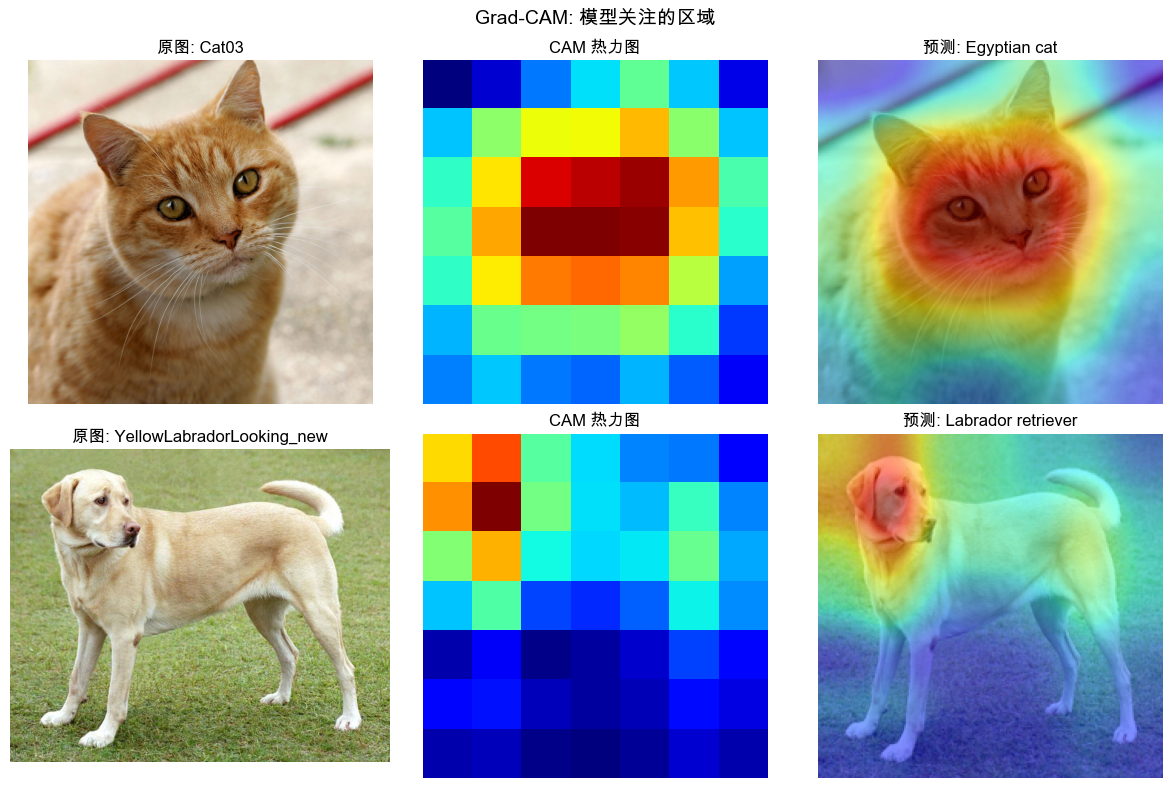


💡 观察：
   - 红色区域是模型做决策时最关注的部分
   - 猫图关注猫脸，狗图关注狗头
   - 这帮助我们理解模型的决策依据


In [17]:
# ============================================================
# Grad-CAM 真实图片演示
# ============================================================

def show_cam_on_image(img, cam, title='Grad-CAM'):
    """将 CAM 叠加到原图上"""
    # 将 PIL Image 转为 numpy array
    if isinstance(img, Image.Image):
        img_array = np.array(img.resize((224, 224))) / 255.0
    else:
        img_array = img
    
    # 调整 CAM 大小
    cam_resized = np.array(Image.fromarray((cam * 255).astype(np.uint8)).resize((224, 224))) / 255.0
    
    # 创建热力图
    heatmap = plt.cm.jet(cam_resized)[:, :, :3]
    
    # 叠加
    overlay = 0.5 * img_array + 0.5 * heatmap
    overlay = np.clip(overlay, 0, 1)
    
    return overlay

# 创建 GradCAM
model_for_cam = models.resnet18(weights='DEFAULT')
model_for_cam.eval()
grad_cam = GradCAM(model_for_cam, model_for_cam.layer4)

# 对所有图片进行 Grad-CAM 可视化
if USE_REAL_IMAGES:
    fig, axes = plt.subplots(len(image_paths), 3, figsize=(12, 4*len(image_paths)))
    
    for row, (name, path) in enumerate(image_paths.items()):
        # 加载图片
        original_img, img_tensor = load_and_preprocess(path)
        img_tensor.requires_grad = True
        
        # 计算 Grad-CAM
        cam, pred_class = grad_cam(img_tensor)
        pred_label = imagenet_labels[pred_class]
        
        # 显示原图
        axes[row, 0].imshow(original_img)
        axes[row, 0].set_title(f'原图: {name}')
        axes[row, 0].axis('off')
        
        # 显示 CAM
        axes[row, 1].imshow(cam, cmap='jet')
        axes[row, 1].set_title(f'CAM 热力图')
        axes[row, 1].axis('off')
        
        # 显示叠加
        overlay = show_cam_on_image(original_img, cam)
        axes[row, 2].imshow(overlay)
        axes[row, 2].set_title(f'预测: {pred_label}')
        axes[row, 2].axis('off')
    
    plt.suptitle('Grad-CAM: 模型关注的区域', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 观察：")
    print("   - 红色区域是模型做决策时最关注的部分")
    print("   - 猫图关注猫脸，狗图关注狗头")
    print("   - 这帮助我们理解模型的决策依据")

grad_cam.remove_hooks()

---

# Part 4: 更多可视化技术

## 4.1 Occlusion Sensitivity（遮挡敏感性）

**原理**：用一个小方块遮挡图像的不同位置，观察预测概率的变化。
- 遮挡关键区域 → 预测概率下降
- 遮挡无关区域 → 预测概率不变

预测类别: Egyptian cat
计算遮挡敏感性...（可能需要几秒钟）


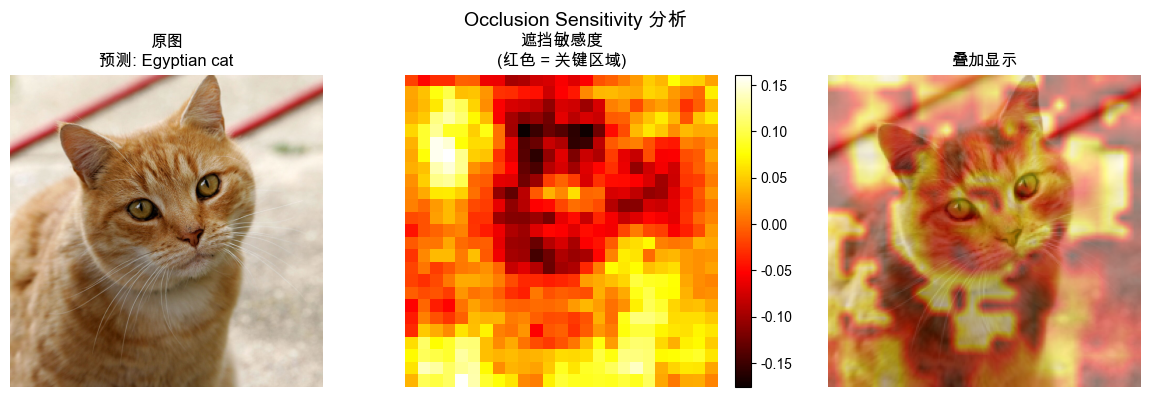


💡 与 Grad-CAM 对比：
   - Grad-CAM: 基于梯度，计算快
   - Occlusion: 基于遮挡实验，更直观但计算慢


In [18]:
# ============================================================
# Occlusion Sensitivity 实现
# ============================================================

def occlusion_sensitivity(model, img_tensor, target_class, patch_size=28, stride=14):
    """
    遮挡敏感性分析
    
    参数：
        model: 模型
        img_tensor: 输入图像 (1, C, H, W)
        target_class: 目标类别
        patch_size: 遮挡块大小
        stride: 遮挡块移动步幅
    
    返回：
        sensitivity_map: 敏感度图 (H', W')
    """
    model.eval()
    _, C, H, W = img_tensor.shape
    
    # 计算原始预测概率
    with torch.no_grad():
        original_output = model(img_tensor)
        original_prob = torch.softmax(original_output, dim=1)[0, target_class].item()
    
    # 创建敏感度图
    n_rows = (H - patch_size) // stride + 1
    n_cols = (W - patch_size) // stride + 1
    sensitivity_map = np.zeros((n_rows, n_cols))
    
    for i in range(n_rows):
        for j in range(n_cols):
            # 复制图像
            occluded = img_tensor.clone()
            
            # 遮挡区域（用灰色填充）
            top = i * stride
            left = j * stride
            occluded[:, :, top:top+patch_size, left:left+patch_size] = 0
            
            # 计算遮挡后的预测概率
            with torch.no_grad():
                output = model(occluded)
                prob = torch.softmax(output, dim=1)[0, target_class].item()
            
            # 敏感度 = 概率下降程度
            sensitivity_map[i, j] = original_prob - prob
    
    return sensitivity_map

# 演示
if USE_REAL_IMAGES:
    test_path = image_paths.get('cat', list(image_paths.values())[0])
    original_img, img_tensor = load_and_preprocess(test_path)
    
    # 获取预测类别
    model_occ = models.resnet18(weights='DEFAULT')
    model_occ.eval()
    
    with torch.no_grad():
        output = model_occ(img_tensor)
        pred_class = output.argmax().item()
    
    print(f"预测类别: {imagenet_labels[pred_class]}")
    print("计算遮挡敏感性...（可能需要几秒钟）")
    
    # 计算敏感度图
    sensitivity = occlusion_sensitivity(
        model_occ, img_tensor, pred_class,
        patch_size=32, stride=8  # 使用较大步幅加速
    )
    
    # 可视化
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # 原图
    axes[0].imshow(original_img)
    axes[0].set_title(f'原图\n预测: {imagenet_labels[pred_class]}')
    axes[0].axis('off')
    
    # 敏感度图
    im = axes[1].imshow(sensitivity, cmap='hot')
    axes[1].set_title('遮挡敏感度\n(红色 = 关键区域)')
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # 叠加显示
    sensitivity_resized = np.array(
        Image.fromarray((sensitivity * 255 / sensitivity.max()).astype(np.uint8))
        .resize((224, 224), Image.BILINEAR)
    ) / 255.0
    
    img_array = np.array(original_img.resize((224, 224))) / 255.0
    heatmap = plt.cm.hot(sensitivity_resized)[:, :, :3]
    overlay = 0.6 * img_array + 0.4 * heatmap
    
    axes[2].imshow(np.clip(overlay, 0, 1))
    axes[2].set_title('叠加显示')
    axes[2].axis('off')
    
    plt.suptitle('Occlusion Sensitivity 分析', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 与 Grad-CAM 对比：")
    print("   - Grad-CAM: 基于梯度，计算快")
    print("   - Occlusion: 基于遮挡实验，更直观但计算慢")

---

## 📝 本章小结

### 可视化技术对比

| 技术 | 原理 | 优点 | 缺点 |
|------|------|------|------|
| **特征图** | 显示中间层输出 | 直观看特征 | 难以解释高层 |
| **Grad-CAM** | 梯度加权激活 | 计算快 | 分辨率低 |
| **Occlusion** | 遮挡实验 | 最直观 | 计算慢 |

### 关键洞察

- **浅层特征**：边缘、颜色、纹理（通用）
- **深层特征**：形状、部件、语义（任务相关）

---

## 🎯 完成 4.1 CNN 模块！

恭喜完成 CNN 学习！接下来可以：
1. 完成 **project_mnist_classifier.py** 项目
2. 进入 **4.2 RNN** 学习序列模型